In [1]:
from baseline import data_loader as load

In [2]:
batch_size = 256

In [3]:
device = load.device
print("device", device)

device cuda:0


In [4]:
d0_train_loader, d0_test_loader, d1_train_loader, d1_test_loader = load.create_dataloader(batch_size=batch_size, enclude_dataset1_y=True)

dataset0 labels:  ['n00020827', 'n01503061', 'n01661818', 'n02075296', 'n02087122', 'n02103406', 'n02159955', 'n03051540', 'n03100490', 'n03122748', 'n03294048', 'n03563967', 'n03574816', 'n04170037', 'n04341686']


/opt/ml/temp/baseline/data_loader.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset0_train_dataset = TensorDataset(torch.tensor(dataset0_X_train).float(), torch.from_numpy(dataset0_y_train))
/opt/ml/temp/baseline/data_loader.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset0_test_dataset = TensorDataset(torch.tensor(dataset0_X_test).float(), torch.from_numpy(dataset0_y_test))


	dataset0 train shape:  torch.Size([256, 368, 5])
	dataset0 test shape:  torch.Size([256, 368, 5])

dataset1 labels:  ['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']



/opt/ml/temp/baseline/data_loader.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1_train_dataset = TensorDataset(torch.tensor(dataset1_X_train).float(), torch.from_numpy(dataset1_y_train))


	dataset1 train shape:  torch.Size([256, 252, 5])
	dataset1 test shape:  torch.Size([256, 252, 5])


/opt/ml/temp/baseline/data_loader.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1_test_dataset = TensorDataset(torch.tensor(dataset1_X_test).float(), torch.from_numpy(dataset1_y_test))


In [5]:
len(d0_train_loader), len(d0_test_loader), len(d1_train_loader), len(d1_test_loader)

(26, 7, 7, 2)

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

from utils import trainer as train
from baseline import evaluator as eval

from model.single_signal_stft_crnn import CRNN, MINDBIG_DATSET0 as cfg0, MINDBIG_DATSET1 as cfg1

In [7]:
print(cfg0)
print()

model = CRNN(n_fft=cfg0["n_fft"], class_num=cfg0["class_num"]).to(device)
print(model)

{'n_fft': 35, 'class_num': 15}

CRNN(
  (STFT): SingleSignalSTFT()
  (Conv1): ConvBlock(
    (bn): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): ConvBlock(
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv3): ConvBlock(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=Fals

In [8]:
summary(model, (365, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  SingleSignalSTFT-1            [-1, 18, 46, 2]               0
       BatchNorm2d-2            [-1, 2, 18, 46]               4
              ReLU-3            [-1, 2, 18, 46]               0
            Conv2d-4           [-1, 16, 18, 46]             304
         MaxPool2d-5            [-1, 16, 9, 23]               0
         ConvBlock-6            [-1, 16, 9, 23]               0
       BatchNorm2d-7            [-1, 16, 9, 23]              32
              ReLU-8            [-1, 16, 9, 23]               0
            Conv2d-9            [-1, 32, 9, 23]           4,640
        MaxPool2d-10            [-1, 32, 3, 11]               0
        ConvBlock-11            [-1, 32, 3, 11]               0
      BatchNorm2d-12            [-1, 32, 3, 11]              64
             ReLU-13            [-1, 32, 3, 11]               0
           Conv2d-14            [-1, 64

/opt/conda/lib/python3.8/site-packages/torch/functional.py:572: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [9]:
lr = 0.0001
epochs = 20

loss_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.8, patience=2)

In [10]:
train.train_dataset0(
    model, d0_train_loader, d0_test_loader, 
    loss_ce, optimizer, scheduler,
    epochs=epochs,
    save_model_dir=".model", device=device
)

epoch #000 train phase - 
	loss : 2.7312, accuracy : 0.0000, macro_f1 : 0.0000
epoch #000 test phase - 
	loss : 2.6663, accuracy : 0.1865, macro_f1 : 0.0781

epoch #001 train phase - 
	loss : 2.7016, accuracy : 0.1657, macro_f1 : 0.0870
epoch #001 test phase - 
	loss : 2.6391, accuracy : 0.1865, macro_f1 : 0.0958

epoch #002 train phase - 
	loss : 2.6780, accuracy : 0.1865, macro_f1 : 0.1771
epoch #002 test phase - 
	loss : 2.6303, accuracy : 0.1865, macro_f1 : 0.0958

epoch #003 train phase - 
	loss : 2.6397, accuracy : 0.1865, macro_f1 : 0.1771
epoch #003 test phase - 
	loss : 2.6296, accuracy : 0.1865, macro_f1 : 0.0958

epoch #004 train phase - 
	loss : 2.6325, accuracy : 0.1865, macro_f1 : 0.1771
epoch #004 test phase - 
	loss : 2.6294, accuracy : 0.1865, macro_f1 : 0.0958

epoch #005 train phase - 
	loss : 2.6309, accuracy : 0.1865, macro_f1 : 0.1771
epoch #005 test phase - 
	loss : 2.6293, accuracy : 0.1865, macro_f1 : 0.0958

epoch #006 train phase - 
	loss : 2.6308, accuracy :

In [11]:
model = CRNN(n_fft=cfg0["n_fft"], class_num=cfg0["class_num"]).to(device)
model.load_state_dict(torch.load(".model/best_model.pt"))

<All keys matched successfully>

In [12]:
print(cfg1)
print()

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=cfg1["class_num"])
print(model)

{'n_fft': 34, 'class_num': 10}

CRNN(
  (STFT): SingleSignalSTFT()
  (Conv1): ConvBlock(
    (bn): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): ConvBlock(
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv3): ConvBlock(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=Fals

In [13]:
model.to(device)
summary(model, (252, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  SingleSignalSTFT-1            [-1, 18, 32, 2]               0
       BatchNorm2d-2            [-1, 2, 18, 32]               4
              ReLU-3            [-1, 2, 18, 32]               0
            Conv2d-4           [-1, 16, 18, 32]             304
         MaxPool2d-5            [-1, 16, 9, 16]               0
         ConvBlock-6            [-1, 16, 9, 16]               0
       BatchNorm2d-7            [-1, 16, 9, 16]              32
              ReLU-8            [-1, 16, 9, 16]               0
            Conv2d-9            [-1, 32, 9, 16]           4,640
        MaxPool2d-10             [-1, 32, 3, 8]               0
        ConvBlock-11             [-1, 32, 3, 8]               0
      BatchNorm2d-12             [-1, 32, 3, 8]              64
             ReLU-13             [-1, 32, 3, 8]               0
           Conv2d-14             [-1, 6

In [14]:
lr = 0.0001
epochs = 50

loss_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.8, patience=2)

In [15]:
train.train_dataset1(
    model, d1_train_loader,
    loss_ce, optimizer, scheduler,
    epochs=epochs,
    save_model_dir=".model", device=device
)

epoch #000 train phase - 
	loss : 2.3058, accuracy : 0.0877, macro_f1 : 0.0368

epoch #001 train phase - 
	loss : 2.3014, accuracy : 0.0883, macro_f1 : 0.0358

epoch #002 train phase - 
	loss : 2.2976, accuracy : 0.0883, macro_f1 : 0.0274

epoch #003 train phase - 
	loss : 2.2939, accuracy : 0.0917, macro_f1 : 0.0298

epoch #004 train phase - 
	loss : 2.2900, accuracy : 0.1009, macro_f1 : 0.0398

epoch #005 train phase - 
	loss : 2.2862, accuracy : 0.1135, macro_f1 : 0.0513

epoch #006 train phase - 
	loss : 2.2822, accuracy : 0.1382, macro_f1 : 0.0558

epoch #007 train phase - 
	loss : 2.2782, accuracy : 0.1560, macro_f1 : 0.0563

epoch #008 train phase - 
	loss : 2.2742, accuracy : 0.1743, macro_f1 : 0.0596

epoch #009 train phase - 
	loss : 2.2701, accuracy : 0.1829, macro_f1 : 0.0618

epoch #010 train phase - 
	loss : 2.2659, accuracy : 0.1864, macro_f1 : 0.0645

epoch #011 train phase - 
	loss : 2.2617, accuracy : 0.1892, macro_f1 : 0.0799

epoch #012 train phase - 
	loss : 2.2575

In [16]:
model = CRNN(n_fft=cfg1["n_fft"], class_num=cfg1["class_num"]).to(device)
model.load_state_dict(torch.load(".model/best_model_transferred.pt"))

<All keys matched successfully>

In [17]:
pd_preds = eval.eval_dataset1(model, d1_test_loader, save_model_dir=".model", device=device, save_submission=True)
pd_preds.head()

,predicted value
0,3
1,3
2,3
3,3
4,3


In [18]:
import pandas as pd

answer = []
for idx, x_y in enumerate(d1_test_loader):
    y = x_y[-1]
    answer.extend(y.cpu().numpy())
torch.cuda.empty_cache()

y_true = pd.DataFrame(answer, columns=['real value'])
y_true.head()

,real value
0,8
1,8
2,8
3,8
4,8


In [19]:
y_pred_true = pd.DataFrame.from_dict({
        "predicted value": pd_preds["predicted value"],
        "real value": y_true["real value"]
    })

y_pred_true.head()

,predicted value,real value
0,3,8
1,3,8
2,3,8
3,3,8
4,3,8


In [20]:
from sklearn.metrics import f1_score
f1_score(y_pred_true["predicted value"], y_pred_true["real value"], average='macro')

0.01818181818181818

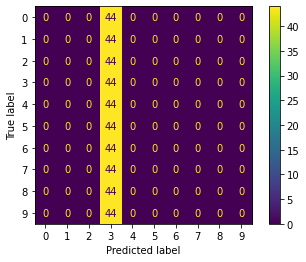

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred_true["real value"], y_pred_true["predicted value"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()